# 随机森林


Cross-Validation Accuracy Scores:  [0.8497 0.8261 0.7563 0.3845 0.4022]
Mean Accuracy:  0.6437600000000001
Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.84      0.72      0.78     42522
           1       0.11      0.20      0.14      7478

    accuracy                           0.64     50000
   macro avg       0.47      0.46      0.46     50000
weighted avg       0.73      0.64      0.68     50000

AUC (Cross-Validation): 0.9998980264502321
Confusion Matrix (Cross-Validation):
 [[30686 11836]
 [ 5976  1502]]


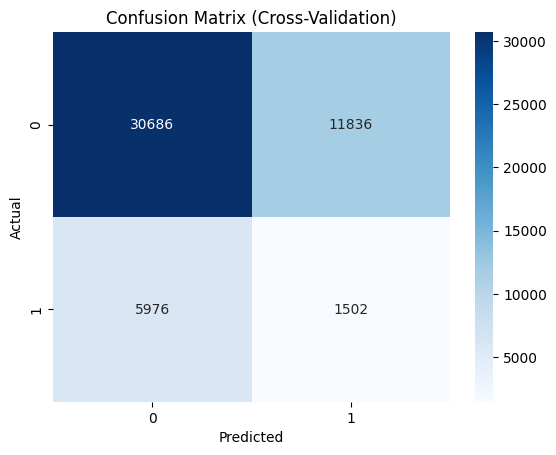

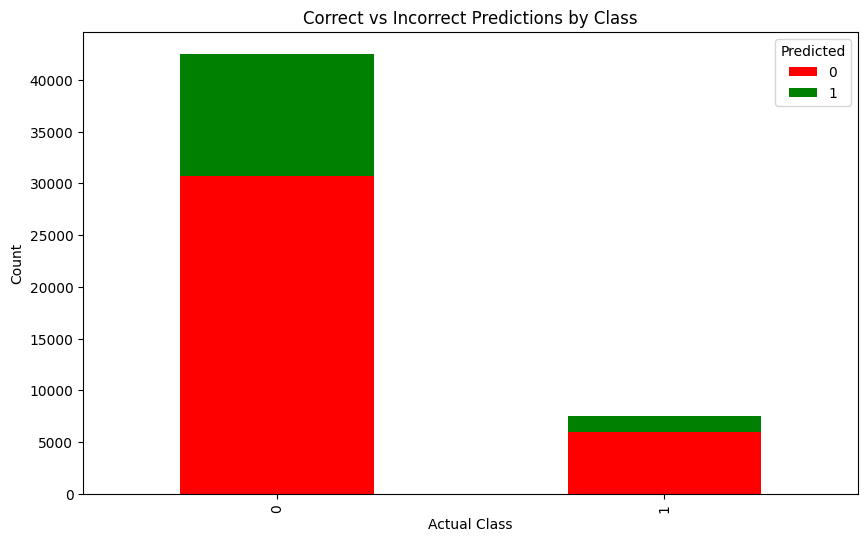

                 Feature  Importance
1          purchase_lead    0.283547
3            flight_hour    0.192116
2         length_of_stay    0.172388
8        flight_duration    0.124685
4             flight_day    0.112437
0         num_passengers    0.057040
7  wants_in_flight_meals    0.022643
5    wants_extra_baggage    0.018303
6   wants_preferred_seat    0.016841


<Figure size 1000x800 with 0 Axes>

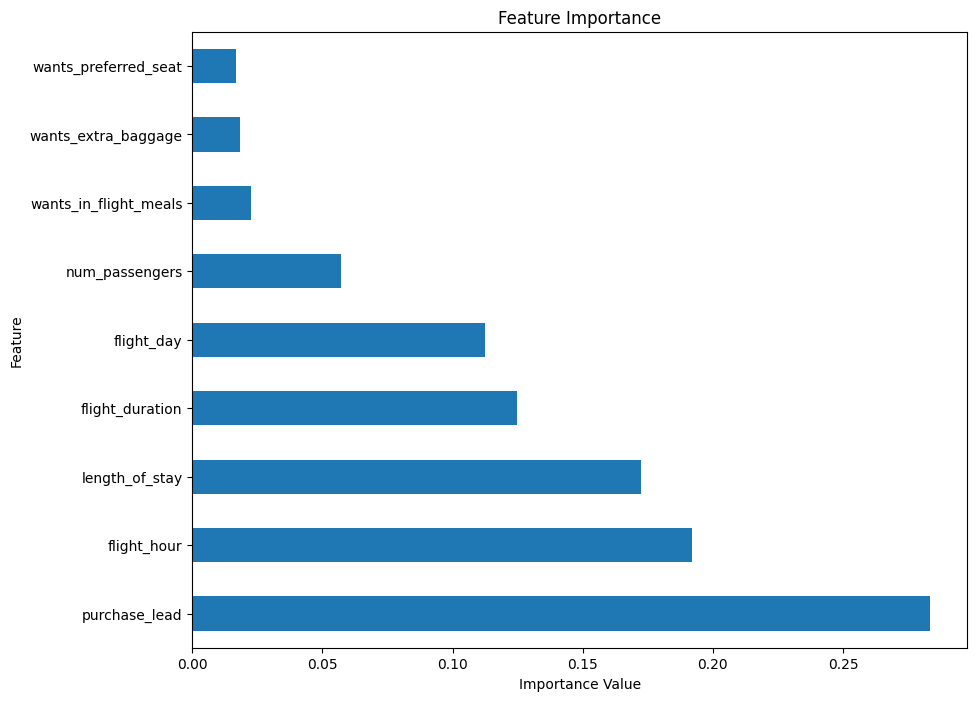

In [2]:
"""
项目背景：使用50000条客户预定航班的数据，训练一个机器学习模型，用来预测客户的预订航班行为。分析是哪些因素影响了旅客最终
的成功预定。并且对模型的预测精度进行评估。
"""

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")

# 展示星期几的对应数值
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}
df["flight_day"] = df["flight_day"].map(mapping)

# 选择数值型数据列
df_numeric = df.select_dtypes(include=['number'])

# 分割数据集：特征变量 X 和目标变量 y
X = df_numeric.drop('booking_complete', axis=1)
y = df_numeric['booking_complete']

# 构建随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# 进行交叉验证
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # 5折交叉验证
print("Cross-Validation Accuracy Scores: ", cv_scores)
print("Mean Accuracy: ", cv_scores.mean())

# 获取交叉验证的预测结果
y_pred_cv = cross_val_predict(model, X, y, cv=5)

# 打印分类报告
print('Classification Report (Cross-Validation):\n', classification_report(y, y_pred_cv))

# 计算 AUC
# 这里需要用交叉验证预测的概率来计算 AUC
model.fit(X, y)  # 先训练模型
y_proba_cv = model.predict_proba(X)[:, 1]  # 获取正类的概率
print('AUC (Cross-Validation):', roc_auc_score(y, y_proba_cv))

# 打印混淆矩阵
print('Confusion Matrix (Cross-Validation):\n', confusion_matrix(y, y_pred_cv))

# 混淆矩阵热力图
sns.heatmap(confusion_matrix(y, y_pred_cv), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Cross-Validation)')
plt.show()

# 推测和实际结果的对比：文图同步
results_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred_cv})

# 历史数据分类结果的堆积条形图
confusion_results = results_df.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)
confusion_results.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])
plt.xlabel('Actual Class')
plt.ylabel('Count')
plt.title('Correct vs Incorrect Predictions by Class')
plt.show()

# 特征重要性的可视化
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 打印特征重要性
print(feature_importances)

# 用柱状图可视化特征重要性
plt.figure(figsize=(10, 8))
feature_importances.set_index('Feature').plot(kind='barh', legend=False, figsize=(10, 8))
plt.xlabel('Importance Value')
plt.title('Feature Importance')
plt.show()
